# CAPM Analysis on the MANGO Portfolio
#### Microsoft, Apple, NVIDIA, Google, Amazon (2023–2024)

This report evaluates the MANGO portfolio using the Capital Asset Pricing Model (CAPM) to assess its sensitivity to market risk and performance relative to theoretical expectations. The market proxy is the S&P 500 Index (^GSPC), and we assume a risk-free rate of 3%.

We analyze:
- Historical returns
- Regression on market risk (beta)
- Visualization of the Security Market Line (SML)
- Risk-adjusted metrics: Sharpe, Treynor, and Jensen's Alpha

In [11]:
# Importing libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm


In [12]:
# Tickers
mango_tickers = ['MSFT', 'AAPL', 'NVDA', 'GOOGL', 'AMZN']
market_ticker = '^GSPC'

# Download adjusted close prices
print("Downloading data...")
raw_data = yf.download(mango_tickers + [market_ticker], start='2023-07-01', end='2024-07-01')

# Handle MultiIndex structure - extract Close prices (already adjusted)
if isinstance(raw_data.columns, pd.MultiIndex):
    data = raw_data['Close']  
else:
    # If single ticker, yfinance returns simple columns
    print("\nSimple columns detected...")
    data = raw_data

# Rename market column
data = data.rename(columns={market_ticker: 'Market'})



/var/folders/cf/py2r6m5s0z97pl9l1w028rlr0000gn/T/ipykernel_54054/4068846427.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_data = yf.download(mango_tickers + [market_ticker], start='2023-07-01', end='2024-07-01')
[                       0%                       ]

[*********************100%***********************]  6 of 6 completed


In [13]:
# Ratio of today's price to yesterday's price, then log transform
# Compute log returns
log_returns = np.log(data / data.shift(1)).dropna() 

# Compute equally weighted MANGO portfolio return
mango_returns = log_returns[mango_tickers].mean(axis=1)
log_returns['MANGO'] = mango_returns

## CAPM Regression

We regress MANGO's returns against market returns to estimate alpha and beta.

In [ ]:
# Prepare regression variables
X = sm.add_constant(log_returns['Market'])  # Market returns (independent)
y = log_returns['MANGO']                    # MANGO portfolio returns (dependent)

# Run CAPM regression
print("\nRunning CAPM regression...")
capm_model = sm.OLS(y, X).fit() # add error handling by minimising the sum of squared residuals



Running CAPM regression...


This sets up the model:

$$R_i = \alpha + \beta R_m + \epsilon$$

Where:
- $R_i$: Return of the **MANGO portfolio**
- $R_m$: Return of the **market** (S&P 500)
- $\alpha$: Intercept (**Jensen's alpha**)
- $\beta$: Market sensitivity (**beta**)
- $\epsilon$: Error term

In [15]:
print(capm_model.summary())


                            OLS Regression Results                            
Dep. Variable:                  MANGO   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     438.4
Date:                Thu, 31 Jul 2025   Prob (F-statistic):           1.14e-56
Time:                        23:51:33   Log-Likelihood:                 852.57
No. Observations:                 249   AIC:                            -1701.
Df Residuals:                     247   BIC:                            -1694.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      1.186      0.2

## Visualization: MANGO vs Market Return
The scatterplot below shows how the MANGO portfolio returns relate to S&P 500 returns. The red line is the best-fit CAPM regression.


Key CAPM Statistics:
Alpha (intercept): 0.000599
Beta (market sensitivity): 1.4954
R-squared: 0.6396


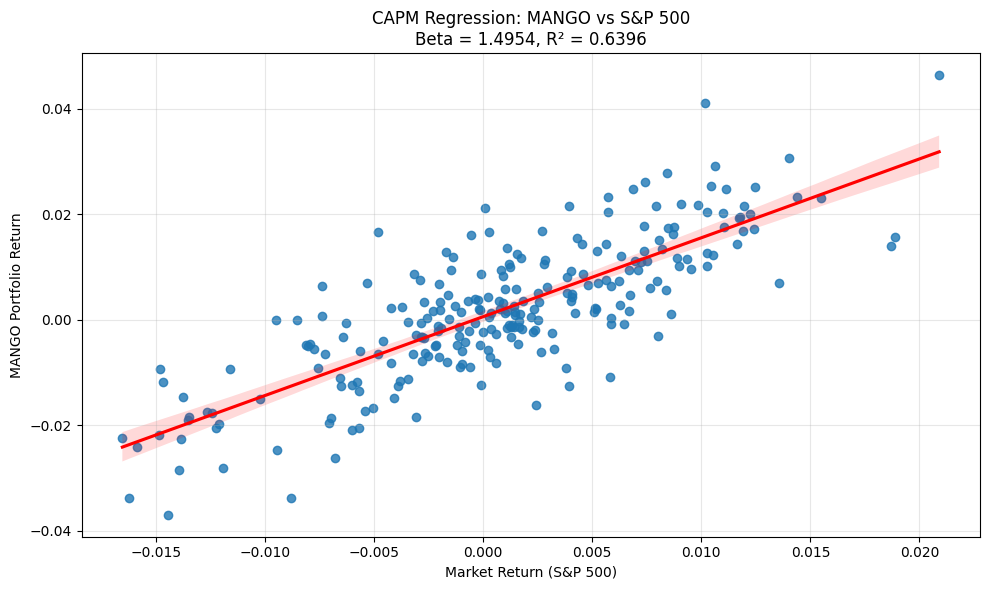


Annualized Statistics:
Market (S&P 500) Return: 0.2058 (20.58%)
Market Volatility: 0.1117 (11.17%)
MANGO Actual Return: 0.4587 (45.87%)
MANGO Volatility: 0.2089 (20.89%)
CAPM Expected Return: 0.2929 (29.29%)


In [ ]:

# Extract key statistics
alpha = capm_model.params['const']
beta = capm_model.params['Market']
r_squared = capm_model.rsquared

print(f"\nKey CAPM Statistics:")
print(f"Alpha (intercept): {alpha:.6f}")
print(f"Beta (asset's sensitivity to market returns): {beta:.4f}")
print(f"R-squared: {r_squared:.4f}")

# Plot CAPM regression
plt.figure(figsize=(10, 6))
sns.regplot(x='Market', y='MANGO', data=log_returns, line_kws={'color': 'red'})
plt.title(f'CAPM Regression: MANGO vs S&P 500\nBeta = {beta:.4f}, R² = {r_squared:.4f}')
plt.xlabel('Market Return (S&P 500)')
plt.ylabel('MANGO Portfolio Return')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate annualized statistics
rf = 0.03  # Assume 3% risk-free rate
mean_market_annual = log_returns['Market'].mean() * 252 # 252 trading days in a year
mean_mango_annual = log_returns['MANGO'].mean() * 252
std_market_annual = log_returns['Market'].std() * np.sqrt(252)
std_mango_annual = log_returns['MANGO'].std() * np.sqrt(252)

# CAPM expected return
capm_expected_return = rf + beta * (mean_market_annual - rf)

print(f"\nAnnualized Statistics:")
print(f"Market (S&P 500) Return: {mean_market_annual:.4f} ({mean_market_annual*100:.2f}%)")
print(f"Market Volatility: {std_market_annual:.4f} ({std_market_annual*100:.2f}%)")
print(f"MANGO Actual Return: {mean_mango_annual:.4f} ({mean_mango_annual*100:.2f}%)")
print(f"MANGO Volatility: {std_mango_annual:.4f} ({std_mango_annual*100:.2f}%)")
print(f"CAPM Expected Return: {capm_expected_return:.4f} ({capm_expected_return*100:.2f}%)")


## Security Market Line

This chart shows where the MANGO portfolio lies relative to the CAPM-predicted return based on its beta.

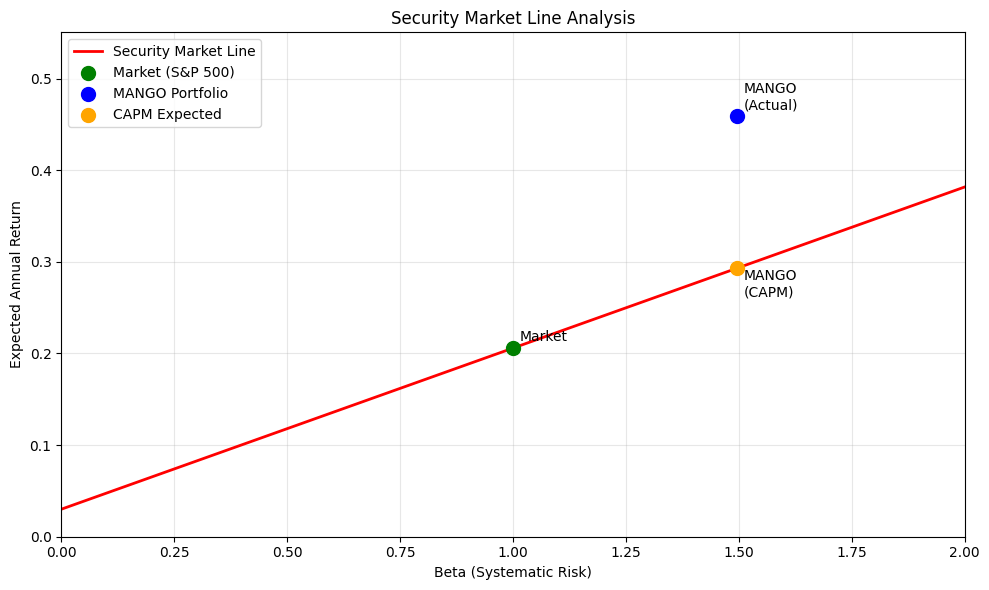


Risk-Adjusted Performance:
Market Sharpe Ratio: 1.5737
MANGO Sharpe Ratio: 2.0521
MANGO Treynor Ratio: 0.2867
Jensen's Alpha: 0.1658 (16.58%)
The MANGO portfolio outperformed its CAPM expected return.


In [ ]:

# Plot Security Market Line
plt.figure(figsize=(10, 6))
beta_range = np.linspace(0, 2, 100)
sml_returns = rf + beta_range * (mean_market_annual - rf)

plt.plot(beta_range, sml_returns, 'r-', label='Security Market Line', linewidth=2)
plt.scatter(1.0, mean_market_annual, color='green', s=100, label='Market (S&P 500)', zorder=5)
plt.scatter(beta, mean_mango_annual, color='blue', s=100, label='MANGO Portfolio', zorder=5)
plt.scatter(beta, capm_expected_return, color='orange', s=100, label='CAPM Expected', zorder=5)

# Add annotations
plt.annotate('Market', (1.0, mean_market_annual), xytext=(5, 5), 
             textcoords='offset points', fontsize=10)
plt.annotate('MANGO\n(Actual)', (beta, mean_mango_annual), xytext=(5, 5), 
             textcoords='offset points', fontsize=10)
plt.annotate('MANGO\n(CAPM)', (beta, capm_expected_return), xytext=(5, -20), 
             textcoords='offset points', fontsize=10)

plt.xlabel('Beta (Systematic Risk)')
plt.ylabel('Expected Annual Return')
plt.title('Security Market Line Analysis')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 2)
plt.ylim(0, max(mean_market_annual, mean_mango_annual) * 1.2)
plt.tight_layout()
plt.show()

# Performance metrics
sharpe_market = (mean_market_annual - rf) / std_market_annual
sharpe_mango = (mean_mango_annual - rf) / std_mango_annual # How much excess return per unit of risk
treynor_mango = (mean_mango_annual - rf) / beta # How much excess return per unit of systematic risk

print(f"\nRisk-Adjusted Performance:")
print(f"Market Sharpe Ratio: {sharpe_market:.4f}")
print(f"MANGO Sharpe Ratio: {sharpe_mango:.4f}")
print(f"MANGO Treynor Ratio: {treynor_mango:.4f}")

# Jensen's Alpha (annualized)
jensen_alpha = mean_mango_annual - capm_expected_return
print(f"Jensen's Alpha: {jensen_alpha:.4f} ({jensen_alpha*100:.2f}%)")

if jensen_alpha > 0:
    print("The MANGO portfolio outperformed its CAPM expected return.")
else:
    print("The MANGO portfolio underperformed its CAPM expected return.")

## Conclusion


- The beta of the MANGO portfolio is 1.49, indicating higher market sensitivity.
- The R² of the regression is 0.640, meaning that 64.0% of return variance is explained by market movements.
- Jensen's Alpha is positive, indicating that the portfolio outperformed CAPM expectations.

This exercise demonstrates the application of CAPM in analyzing real portfolio returns using Python, and prepares the groundwork for developing more advanced multi-factor models or portfolio construction algorithms.
